In [1]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy.random as rnd
from scipy.stats import chi

In [8]:
width_LG = 48/np.sqrt(2)   #µm

k_B = 1.38*10**-23   #µm^2 Kg ms^-2 µK^-1

m_Rb = 85*1.6*10**-27    #kg

h = 6.62*10**-25   # µm^2 kg ms^-1

omega_l = 2*np.pi*(3*10**5)/(1064*10**-9)  #ms^-1

m_e = 9.1*10**-31   #kg

beta = (1/137)* h /(m_e * omega_l**2)   #proportionality factor b/w energy & intensity, µm^2 ms


noise_points = (np.random.rand(20,2)*161-80).astype(int)
noise_widths = np.random.rand(20)*20+10
noise_dir = (np.random.rand(20) > .5)*2-1
noise_amps = np.random.rand(20)*15


def noise(x,y):
    res = 0
    for i in range(20):
        x_0 = noise_points[i,0]
        y_0 = noise_points[i,1]
        res += noise_amps[i]*noise_dir[i]/np.sqrt(2*np.pi*noise_widths[i]**2)*np.exp(-((x-x_0)**2+(y-y_0)**2)/(2*noise_widths[i]**2))
    return res

def LG(x, y, w, P):      #J ms^-1 µm^-2
    r2 = x**2 + y**2
    return P*(4*r2/(np.pi*w**4)*np.exp(-2*r2/w**2))*(1+noise(x,y))

def E(x, y, w, P):       #J
    return LG(x, y, w, P)*beta

def dxLG(x, y, w, P):     #J ms^-1 µm^-3
    r2 = x**2 + y**2
    return P*(8*x/(np.pi*w**4)*np.exp(-2*r2/w**2))*(1-2*r2/w**2)

def dyLG(x, y, w, P):     #J ms^-1 µm^-3
    r2 = x**2 + y**2
    return P*(8*y/(np.pi*w**4)*np.exp(-2*r2/w**2))*(1-2*r2/w**2)

def dxE(x, y, w, P):      # J µm^-1
    return dxLG(x, y, w, P)*beta


def dyE(x, y, w, P):      # J µm^-1
    return dyLG(x, y, w, P)*beta

class Atoms(object):
    
    def __init__(self, n_atoms, temp, w_g, x_0, p_0, freq, A, t):
        """Create an atom"""
        
        self.n_atoms = n_atoms
        
        self.temperature = temp
        
        self.x_velocities = np.random.normal(0, np.sqrt(k_B*temp/m_Rb), n_atoms)
        self.y_velocities = np.random.normal(0, np.sqrt(k_B*temp/m_Rb), n_atoms)    #in µm ms^-1
        
        self.x_positions = np.random.normal(x_0, w_g/2, n_atoms)     #in µm
        self.y_positions = np.random.normal(0, w_g/2, n_atoms)
        
        self.avg_power = p_0
        
        self.power = p_0
        
        self.z_positions = E(self.x_positions, self.y_positions, width_LG, self.power)/(k_B*10**-6)   #kB in m^2 Kg s^-2 µK^-1
        
        self.freq = freq
        
        self.amp = A/100
        
        self.x_forces = -dxE(self.x_positions, self.y_positions, width_LG, self.power)    #J µm^-1
        self.y_forces = -dyE(self.x_positions, self.y_positions, width_LG, self.power)
        
        self.time = t

            
    def step(self, dt):
        self.x_positions += dt * self.x_velocities
        self.y_positions += dt * self.y_velocities
        
        self.z_positions = E(self.x_positions, self.y_positions, width_LG, self.power)/(k_B*10**-6)
        
        self.x_velocities += dt * (10**6)*self.x_forces/m_Rb     #10**6 to convert J=kg*m^2*s^-2 to kg*µm^2*ms^-2
        self.y_velocities += dt * (10**6)*self.y_forces/m_Rb
        
        self.x_forces = -dxE(self.x_positions, self.y_positions, width_LG, self.power)
        self.y_forces = -dyE(self.x_positions, self.y_positions, width_LG, self.power)
        
        self.power -= (self.amp/2)*self.avg_power*(2*np.pi*self.freq)*np.sin(2*np.pi*self.freq*self.time)*dt
        self.time += dt

<IPython.core.display.Javascript object>


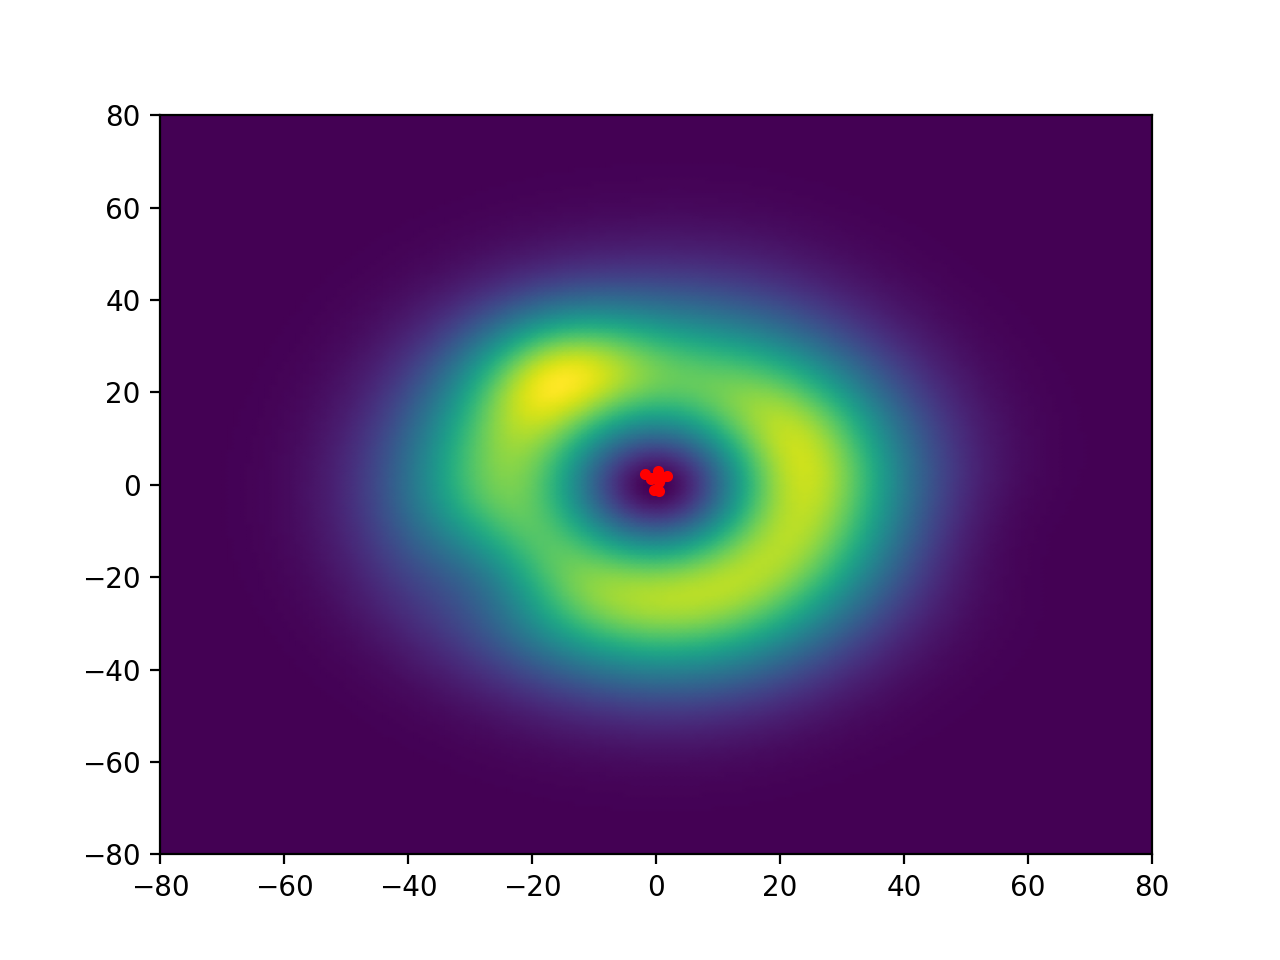

In [12]:
N_at = 10

temperature =  5     #µK

width_blue = 3   #µm

init_offset = 0   #µm

P_0 = 6.*10**-3    #J ms^-1

freq_modulation = 0.    #kHz

amp_modulation = 0.   # in % of power

X = np.linspace(-80,80,161)
Y = np.linspace(-80,80, 161)
XX, YY = np.meshgrid(X, Y)

atoms = Atoms(N_at,  temperature, width_blue, init_offset, P_0, freq_modulation, amp_modulation, 0)

fig = plt.figure()
#ax = plt.subplot(111)
trap = plt.pcolormesh(XX,YY, E(XX, YY, width_LG, atoms.power)/(k_B*10**-6),shading='gouraud')
#cb = fig.colorbar(quad)
at, = plt.plot([], [], marker='.', color='red', linestyle='none')

def init():
    at.set_data([],[])
    #trap.set_array([])
    return at,

def animate(i):
    atoms.step(0.001)   #time step, in ms; 1 µs steps
    #z =  E(XY, YY, width_LG, atoms.power)
    at.set_data(atoms.x_positions, atoms.y_positions)
    #trap.set_array(z.ravel())
    return at,

anim = animation.FuncAnimation(fig,animate,interval=1,blit=False)
#plt.show()

<IPython.core.display.Javascript object>


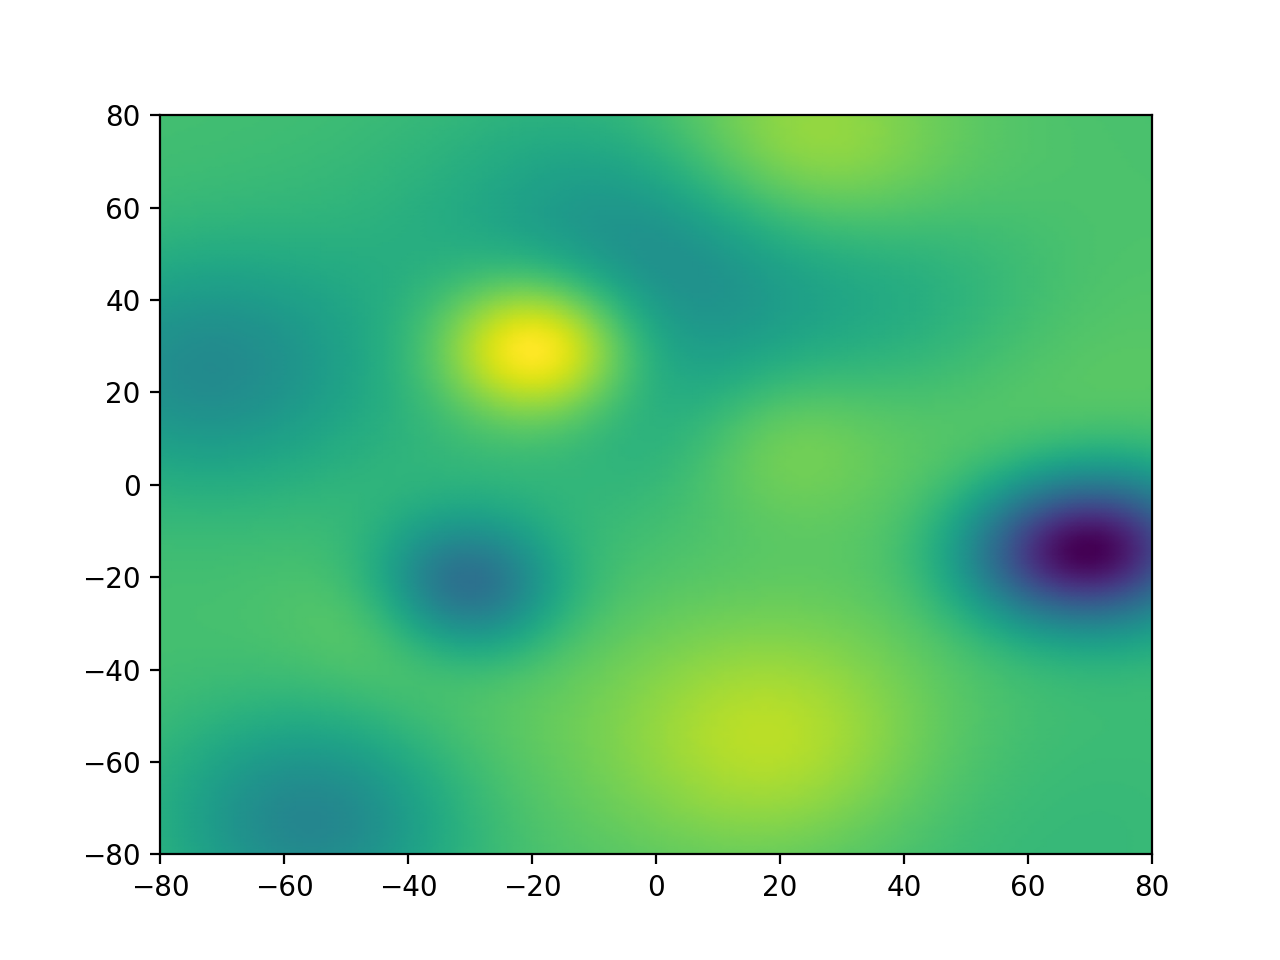

In [10]:
plt.figure()
X = np.linspace(-80,80,161)
Y = np.linspace(-80,80, 161)
XX, YY = np.meshgrid(X, Y)
plt.pcolormesh(XX,YY, noise(XX, YY),shading='gouraud')

<IPython.core.display.Javascript object>


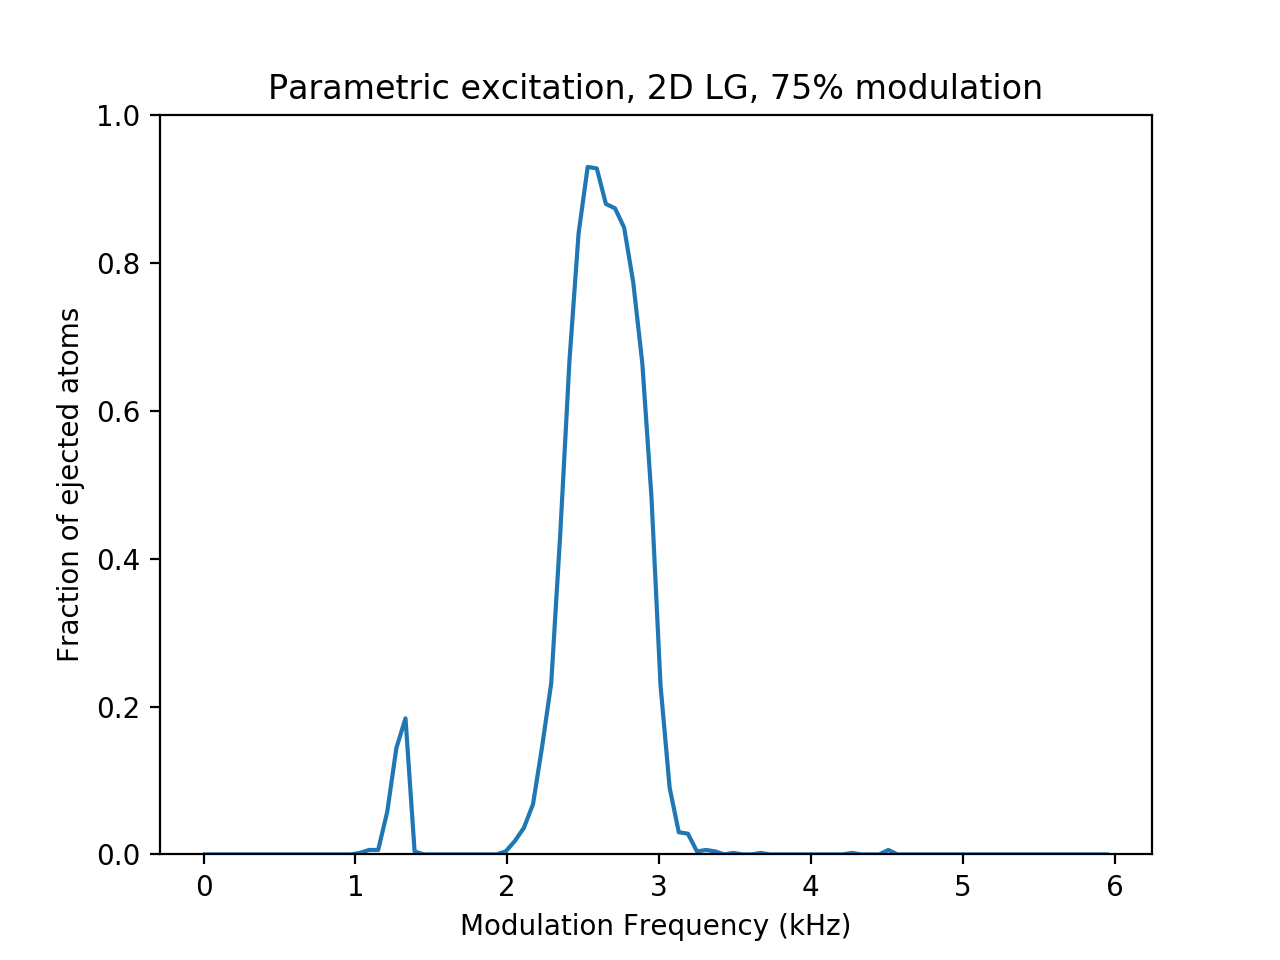

In [14]:
frac = np.zeros(100)
frequencies = np.zeros(100)
for i in range(100):
    frequencies[i] = 0.01+i*0.06
    
total_time = 5.5

N_at = 500

temperature =  5  #µK

width_blue = 3    #µm

init_offset = 0   #µm

P_0 = 6.*10**-3    #J ms^-1

amp_modulation = 75   # in % of power

for i in range(100):
    freq_modulation = frequencies[i]

    atoms = Atoms(N_at,  temperature, width_blue, init_offset, P_0, frequencies[i], amp_modulation, 0)

    for j in range(int(total_time/0.0005)):
        atoms.step(0.0005)
        
    for k in range(N_at):
        if(atoms.x_positions[k]**2 + atoms.y_positions[k]**2 > 40**2):
            frac[i] +=1
plt.figure()
plt.plot(frequencies, frac/N_at)
plt.ylim(0,1)
plt.xlabel('Modulation Frequency (kHz)')
plt.ylabel('Fraction of ejected atoms')
plt.title('Parametric excitation, 2D LG, ' + str(amp_modulation) + '% modulation')
plt.savefig('2DsimLG.png', format = 'png', dpi = 1000)